In [1]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, LeaveOneOut, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import seaborn as sns
import optuna

In [2]:
def get_label_from_filename(fname):
    fname = fname.lower()
    if "normal" in fname:
        return 0
    elif "murmur" in fname:
        return 1
    elif "artifact" in fname:
        return 2
    elif "extrahls" in fname:
        return 3
    else:
        return None

In [3]:
def butter_bandpass_filter(signal, lowcut=20, highcut=400, fs=1000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [4]:
def extract_mfcc(cycle, sr, n_mfcc=13, max_len=260):
    mfcc = librosa.feature.mfcc(y=cycle.astype(np.float32), sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=128)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc
base_path = "/kaggle/input/heartbeat-sounds"
data_dirs = [os.path.join(base_path, "set_a"), os.path.join(base_path, "set_b")]
all_files = []
for folder in data_dirs:
    all_files += glob.glob(os.path.join(folder, "*.wav"))

print(f"Total files: {len(all_files)}")

Total files: 832


In [5]:
X_features = []
y_labels = []
skipped_files = 0
skipped_paths = []

label_counter = {0: 0, 1: 0, 2: 0, 3: 0}

In [6]:
for idx, file_path in enumerate(all_files):
    audio, sr = librosa.load(file_path, sr=None)
    if sr != 1000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=1000)
        sr = 1000

    audio = audio / np.max(np.abs(audio))
    filtered_audio = butter_bandpass_filter(audio, fs=sr)

    analytic_signal = hilbert(filtered_audio)
    envelope = np.abs(analytic_signal)

    peaks, _ = find_peaks(
        envelope,
        distance=int(0.4 * sr),
        height=np.mean(envelope) * 1.2
    )

    cardiac_cycles = []
    if len(peaks) >= 3:
        for i in range(len(peaks) - 2):
            start = peaks[i]
            end = peaks[i + 2]
            if end > start:
                cycle = filtered_audio[start:end]
                cardiac_cycles.append(cycle)
    else:
        print(f" Skipped {os.path.basename(file_path)}: Not enough peaks ({len(peaks)})")

    label = get_label_from_filename(file_path)
    if label is not None:
        label_counter[label] += 1
        for cycle in cardiac_cycles:
            mfcc = extract_mfcc(cycle, sr)
            X_features.append(mfcc.flatten())
            y_labels.append(label)
    else:
        skipped_files += 1
        skipped_paths.append(file_path)

 Skipped extrahls__201104021355.wav: Not enough peaks (2)
 Skipped artifact__201106121445.wav: Not enough peaks (2)
 Skipped murmur__201104021355.wav: Not enough peaks (2)
 Skipped Bunlabelledtest__235_1308749032454_C1.wav: Not enough peaks (2)
 Skipped normal__210_1308162935880_D2.wav: Not enough peaks (2)
 Skipped Bunlabelledtest__296_1311682952647_A.wav: Not enough peaks (2)
 Skipped normal__134_1306428161797_C2.wav: Not enough peaks (2)
 Skipped normal__210_1308162935880_D1.wav: Not enough peaks (2)
 Skipped Bunlabelledtest__155_1306935902813_B.wav: Not enough peaks (2)
 Skipped murmur__171_1307971016233_E.wav: Not enough peaks (2)
 Skipped Bunlabelledtest__290_1311182875320_B.wav: Not enough peaks (2)
 Skipped normal__238_1309194586293_A.wav: Not enough peaks (2)
 Skipped normal__286_1311170606028_A1.wav: Not enough peaks (2)
 Skipped Bunlabelledtest__163_1307104470471_B1.wav: Not enough peaks (2)
 Skipped normal__143_1306763822290_C.wav: Not enough peaks (2)
 Skipped normal__235_

In [7]:
X = np.array(X_features)
y = np.array(y_labels)

print(f"Extracted MFCC features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique class labels: {np.unique(y)}")
print(f"Skipped files with undefined labels: {skipped_files}")

Extracted MFCC features shape: (4899, 3380)
Labels shape: (4899,)
Unique class labels: [0 1 2 3]
Skipped files with undefined labels: 293


In [8]:
# Display how many files were labeled with each class
for k, v in label_counter.items():
    print(f"Class {k} count: {v}")

Class 0 count: 351
Class 1 count: 129
Class 2 count: 40
Class 3 count: 19


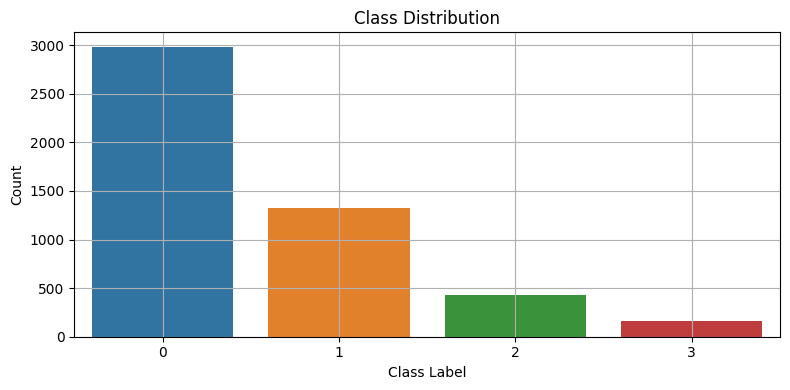

In [9]:
# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       596
           1       0.92      0.36      0.52       265
           2       0.93      0.87      0.90        86
           3       0.72      0.55      0.62        33

    accuracy                           0.78       980
   macro avg       0.83      0.69      0.72       980
weighted avg       0.81      0.78      0.76       980



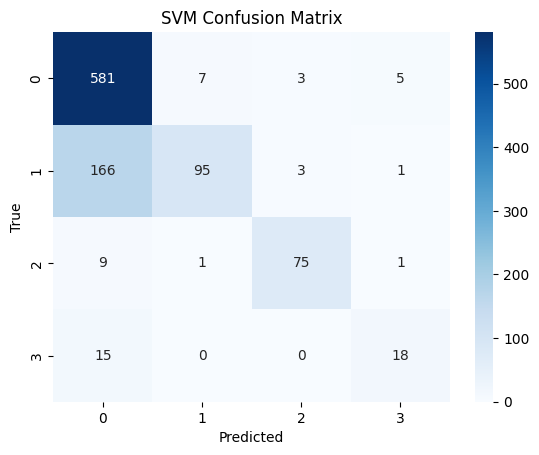


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.95      0.42      0.58       265
           2       0.92      0.91      0.91        86
           3       1.00      0.42      0.60        33

    accuracy                           0.80       980
   macro avg       0.91      0.68      0.74       980
weighted avg       0.84      0.80      0.78       980



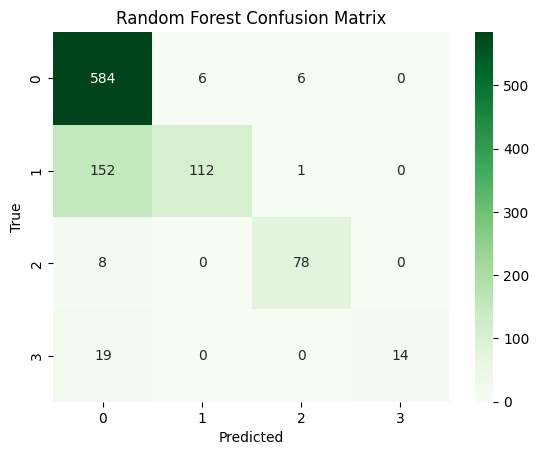


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       596
           1       0.89      0.61      0.72       265
           2       0.88      0.94      0.91        86
           3       0.89      0.76      0.82        33

    accuracy                           0.85       980
   macro avg       0.88      0.81      0.84       980
weighted avg       0.86      0.85      0.84       980



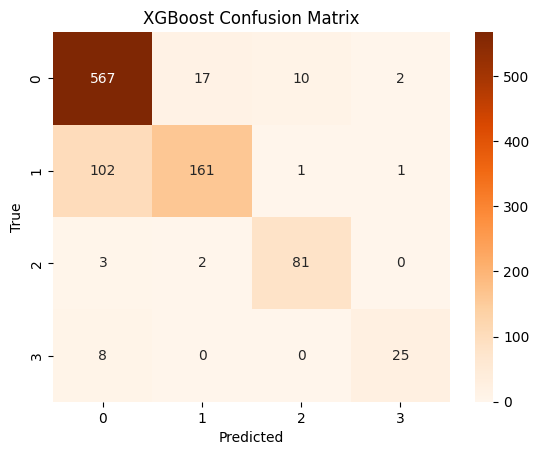

In [10]:
# Classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM GridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       596
           1       0.88      0.68      0.77       265
           2       0.95      0.84      0.89        86
           3       0.82      0.82      0.82        33

    accuracy                           0.86       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.87      0.86      0.86       980



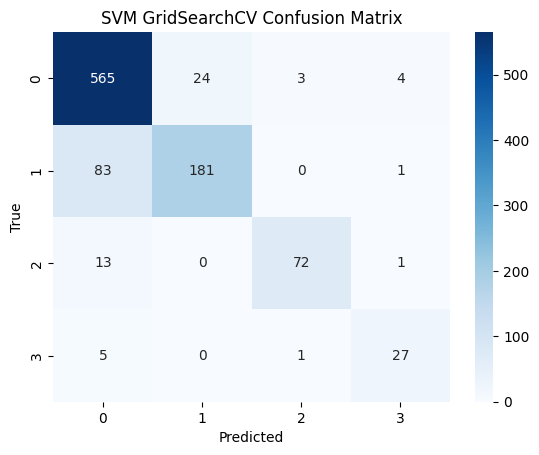


Random Forest GridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.94      0.43      0.59       265
           2       0.93      0.91      0.92        86
           3       1.00      0.39      0.57        33

    accuracy                           0.81       980
   macro avg       0.91      0.68      0.73       980
weighted avg       0.84      0.81      0.78       980



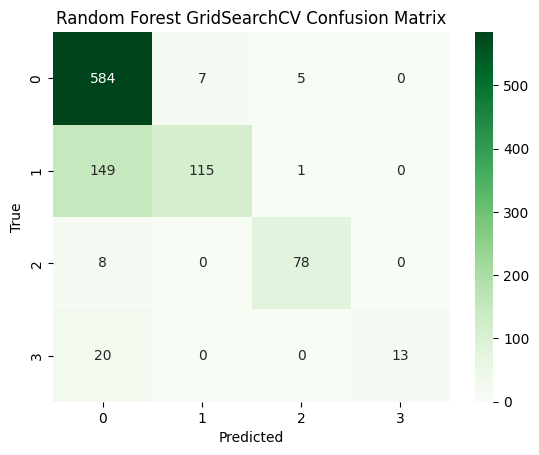


XGBoost GridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       596
           1       0.89      0.63      0.74       265
           2       0.91      0.97      0.94        86
           3       0.85      0.70      0.77        33

    accuracy                           0.86       980
   macro avg       0.87      0.81      0.83       980
weighted avg       0.86      0.86      0.85       980



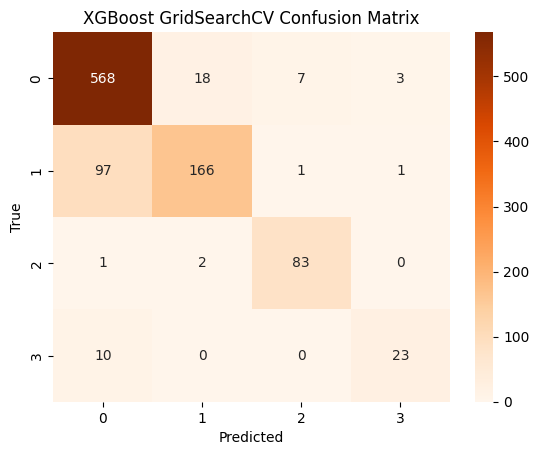

In [11]:
# SVM with GridSearchCV

params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), params, cv=3)
grid.fit(X_train, y_train)
y_pred_svm = grid.predict(X_test)
print("\nSVM GridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM GridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [100, 200],'max_depth': [None, 10, 20],'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("\nRandom Forest GridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest GridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# XGBoost with GridSearchCV
xgb_params = {'n_estimators': [100, 200, 300],'max_depth': [3, 6],'learning_rate': [0.1, 0.01]}
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params, cv=3)
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)
print("\nXGBoost GridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost GridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM StratifiedKFold Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       596
           1       0.88      0.68      0.77       265
           2       0.95      0.84      0.89        86
           3       0.82      0.82      0.82        33

    accuracy                           0.86       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.87      0.86      0.86       980



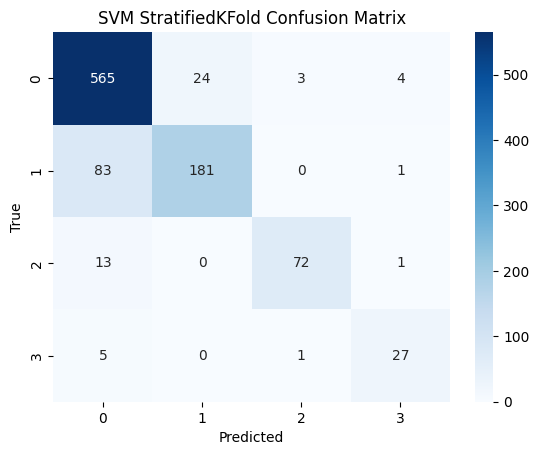


Random Forest StratifiedKFold Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.94      0.43      0.59       265
           2       0.93      0.91      0.92        86
           3       1.00      0.39      0.57        33

    accuracy                           0.81       980
   macro avg       0.91      0.68      0.73       980
weighted avg       0.84      0.81      0.78       980



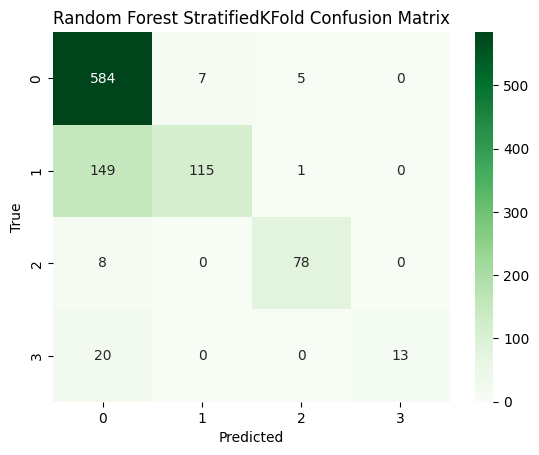


XGBoost StratifiedKFold Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       596
           1       0.91      0.60      0.72       265
           2       0.92      0.97      0.94        86
           3       0.85      0.70      0.77        33

    accuracy                           0.85       980
   macro avg       0.88      0.80      0.83       980
weighted avg       0.86      0.85      0.84       980



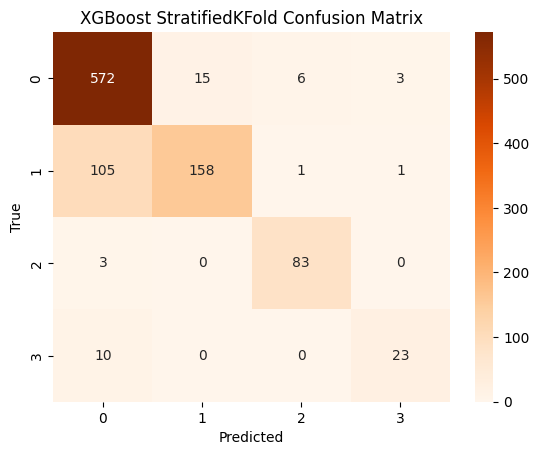

In [12]:
# SVM with StratifiedKFold
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}
grid_svm = GridSearchCV(SVC(), svm_params, cv=StratifiedKFold(n_splits=5))
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
print("\nSVM StratifiedKFold Classification Report:")
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM StratifiedKFold Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest with StratifiedKFold
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=StratifiedKFold(n_splits=5))
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("\nRandom Forest StratifiedKFold Classification Report:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest StratifiedKFold Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# XGBoost with StratifiedKFold
xgb_params = {'n_estimators': [100, 200],'max_depth': [3, 6],'learning_rate': [0.1, 0.01]}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_xgb_stratified = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params, cv=stratified_kfold)
grid_xgb_stratified.fit(X_train, y_train)
y_pred_xgb_stratified = grid_xgb_stratified.predict(X_test)

print("\nXGBoost StratifiedKFold Classification Report:")
print(classification_report(y_test, y_pred_xgb_stratified))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_stratified), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost StratifiedKFold Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM RandomizedSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       596
           1       0.88      0.68      0.77       265
           2       0.95      0.84      0.89        86
           3       0.82      0.82      0.82        33

    accuracy                           0.86       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.87      0.86      0.86       980



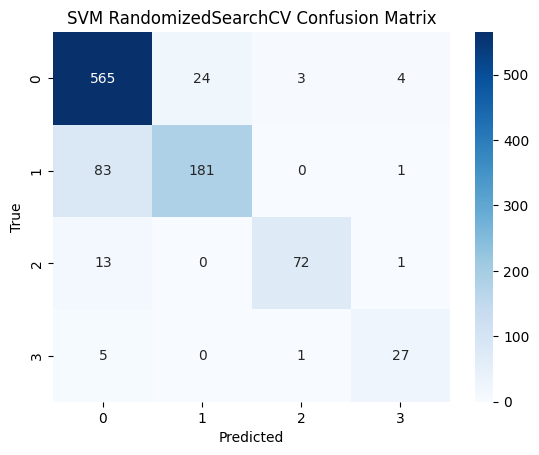


Random Forest RandomizedSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.95      0.42      0.58       265
           2       0.92      0.91      0.91        86
           3       1.00      0.42      0.60        33

    accuracy                           0.80       980
   macro avg       0.91      0.68      0.74       980
weighted avg       0.84      0.80      0.78       980



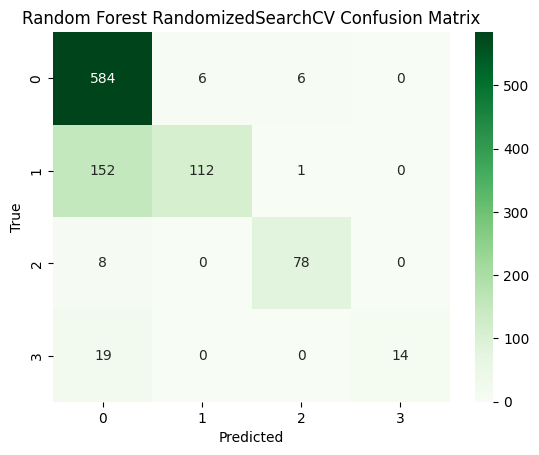


XGBoost RandomizedSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       596
           1       0.89      0.57      0.69       265
           2       0.92      0.94      0.93        86
           3       0.88      0.64      0.74        33

    accuracy                           0.84       980
   macro avg       0.88      0.78      0.81       980
weighted avg       0.85      0.84      0.83       980



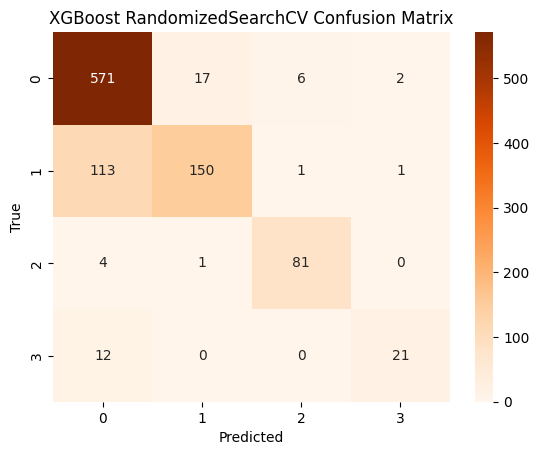

In [13]:
# SVM with RandomizedSearchCV
random_svm = RandomizedSearchCV(SVC(), svm_params, n_iter=2, cv=StratifiedKFold(n_splits=5), random_state=42)
random_svm.fit(X_train, y_train)
y_pred_svm_rand = random_svm.predict(X_test)
print("\nSVM RandomizedSearchCV Classification Report:")
print(classification_report(y_test, y_pred_svm_rand))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_rand), annot=True, fmt='d', cmap='Blues')
plt.title("SVM RandomizedSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest with RandomizedSearchCV
random_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=StratifiedKFold(n_splits=5), random_state=42)
random_rf.fit(X_train, y_train)
y_pred_rf_rand = random_rf.predict(X_test)
print("\nRandom Forest RandomizedSearchCV Classification Report:")
print(classification_report(y_test, y_pred_rf_rand))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_rand), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest RandomizedSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# XGBoost with RandomizedSearchCV
random_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=5,
    cv=StratifiedKFold(n_splits=5),
    random_state=42
)
random_xgb.fit(X_train, y_train)
y_pred_xgb_rand = random_xgb.predict(X_test)
print("\nXGBoost RandomizedSearchCV Classification Report:")
print(classification_report(y_test, y_pred_xgb_rand))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_rand), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost RandomizedSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM HalvingGridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       596
           1       0.89      0.57      0.69       265
           2       0.92      0.91      0.91        86
           3       0.81      0.76      0.78        33

    accuracy                           0.84       980
   macro avg       0.86      0.80      0.82       980
weighted avg       0.85      0.84      0.83       980



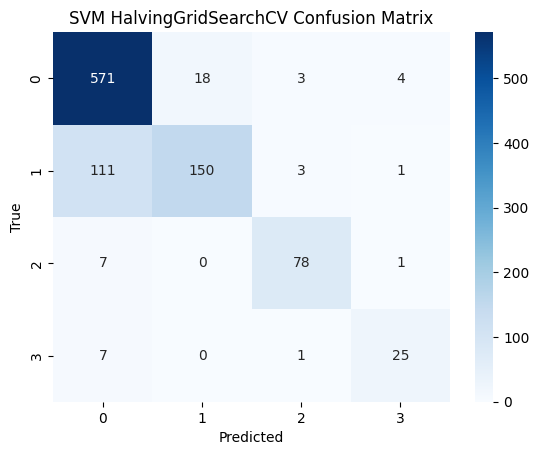


Random Forest HalvingGridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.94      0.43      0.59       265
           2       0.93      0.91      0.92        86
           3       1.00      0.39      0.57        33

    accuracy                           0.81       980
   macro avg       0.91      0.68      0.73       980
weighted avg       0.84      0.81      0.78       980



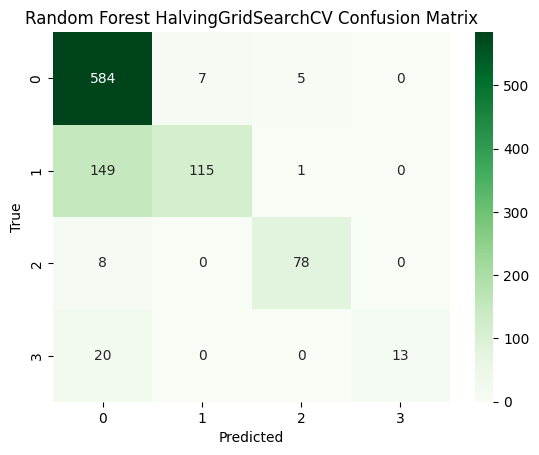


XGBoost HalvingGridSearchCV Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       596
           1       0.91      0.60      0.72       265
           2       0.92      0.97      0.94        86
           3       0.85      0.70      0.77        33

    accuracy                           0.85       980
   macro avg       0.88      0.80      0.83       980
weighted avg       0.86      0.85      0.84       980



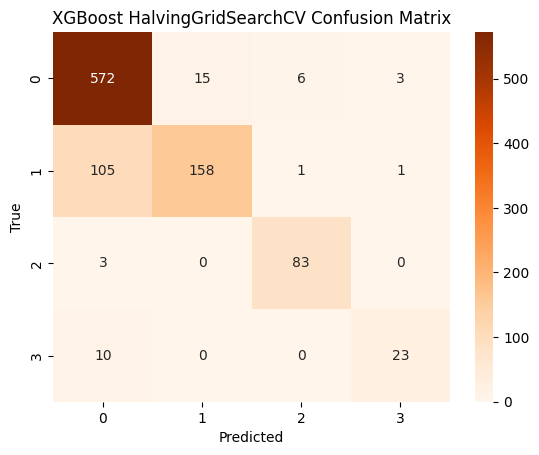

In [14]:
# HalvingGridSearchCV on SVM
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}
halving_svm = HalvingGridSearchCV(SVC(), svm_params, cv=StratifiedKFold(n_splits=5))
halving_svm.fit(X_train, y_train)
y_pred_halving_svm = halving_svm.predict(X_test)
print("\nSVM HalvingGridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_halving_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_halving_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM HalvingGridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# HalvingGridSearchCV on Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
halving_rf = HalvingGridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=StratifiedKFold(n_splits=5))
halving_rf.fit(X_train, y_train)
y_pred_halving_rf = halving_rf.predict(X_test)
print("\nRandom Forest HalvingGridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_halving_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_halving_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest HalvingGridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# HalvingGridSearchCV on XGBoost
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.01]}
halving_xgb = HalvingGridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params, cv=StratifiedKFold(n_splits=5))
halving_xgb.fit(X_train, y_train)
y_pred_halving_xgb = halving_xgb.predict(X_test)
print("\nXGBoost HalvingGridSearchCV Classification Report:")
print(classification_report(y_test, y_pred_halving_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_halving_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost HalvingGridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       596
           1       0.89      0.54      0.68       265
           2       0.91      0.93      0.92        86
           3       0.89      0.73      0.80        33

    accuracy                           0.84       980
   macro avg       0.88      0.79      0.82       980
weighted avg       0.84      0.84      0.82       980



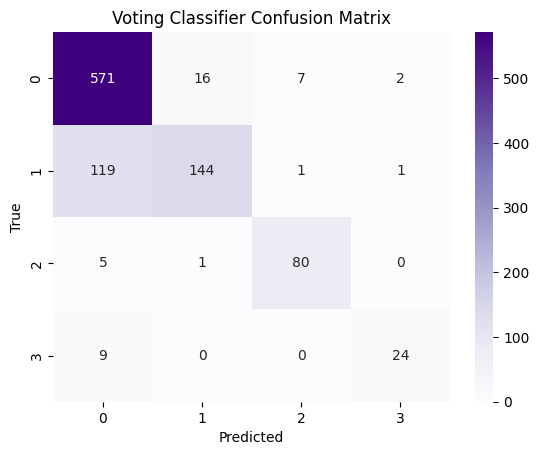

In [15]:
# VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
print("\nVoting Classifier Report:")
print(classification_report(y_test, y_pred_vote))
sns.heatmap(confusion_matrix(y_test, y_pred_vote), annot=True, fmt='d', cmap='Purples')
plt.title("Voting Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       596
           1       0.78      0.57      0.66       265
           2       0.94      0.93      0.94        86
           3       0.81      0.76      0.78        33

    accuracy                           0.82       980
   macro avg       0.84      0.80      0.81       980
weighted avg       0.82      0.82      0.81       980



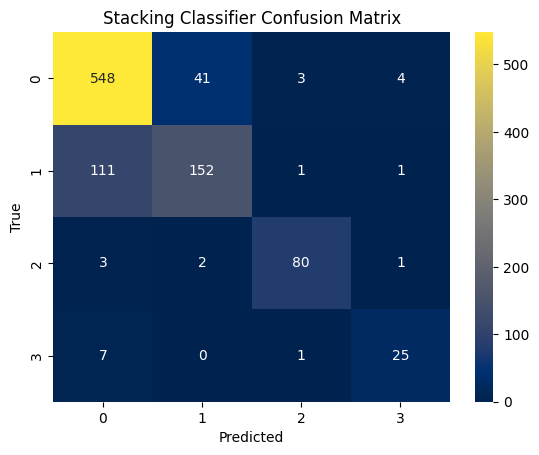

In [16]:
# StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', SVC(probability=True)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
)
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
print("\nStacking Classifier Report:")
print(classification_report(y_test, y_pred_stack))
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='cividis')
plt.title("Stacking Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM - Nested Cross-Validation
Nested CV Accuracy: 0.8118 ± 0.0025

SVM (Nested CV Best) Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       596
           1       0.88      0.68      0.77       265
           2       0.95      0.84      0.89        86
           3       0.82      0.82      0.82        33

    accuracy                           0.86       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.87      0.86      0.86       980



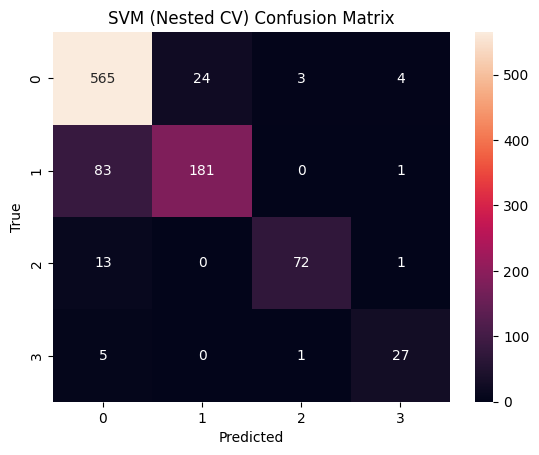


Random Forest - Nested Cross-Validation
Nested CV Accuracy: 0.7889 ± 0.0069

Random Forest (Nested CV Best) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.94      0.43      0.59       265
           2       0.93      0.91      0.92        86
           3       1.00      0.39      0.57        33

    accuracy                           0.81       980
   macro avg       0.91      0.68      0.73       980
weighted avg       0.84      0.81      0.78       980



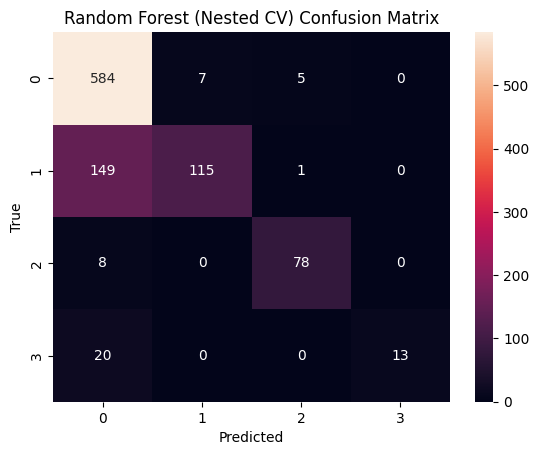


XGBoost - Nested Cross-Validation
Nested CV Accuracy: 0.8343 ± 0.0057

XGBoost (Nested CV Best) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       596
           1       0.91      0.60      0.72       265
           2       0.92      0.97      0.94        86
           3       0.85      0.70      0.77        33

    accuracy                           0.85       980
   macro avg       0.88      0.80      0.83       980
weighted avg       0.86      0.85      0.84       980



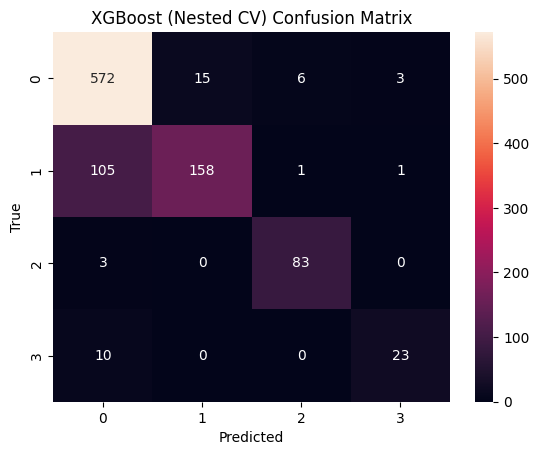

In [17]:
# Nested Cross-Validation for SVM, RF, and XGBoost
outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for name, model, params in [
    ("SVM", SVC(), {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}),
    ("Random Forest", RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10]}),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.01]})
]:
    print(f"\n{name} - Nested Cross-Validation")
    nested_scores = cross_val_score(GridSearchCV(model, params, cv=3), X, y, cv=outer_cv)
    print(f"Nested CV Accuracy: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

    grid_nested = GridSearchCV(model, params, cv=3)
    grid_nested.fit(X_train, y_train)
    y_pred_nested = grid_nested.predict(X_test)

    print(f"\n{name} (Nested CV Best) Classification Report:")
    print(classification_report(y_test, y_pred_nested))
    sns.heatmap(confusion_matrix(y_test, y_pred_nested), annot=True, fmt='d')
    plt.title(f"{name} (Nested CV) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

[I 2025-06-19 12:22:24,404] A new study created in memory with name: no-name-b1a0556b-f8b2-4e2e-bd9f-5750ae639506
[I 2025-06-19 12:23:25,212] Trial 0 finished with value: -0.8076060385570609 and parameters: {'C': 2.6041507916815188, 'gamma': 0.002634201174479158}. Best is trial 0 with value: -0.8076060385570609.
[I 2025-06-19 12:24:27,610] Trial 1 finished with value: -0.707579206948254 and parameters: {'C': 0.9184350976921765, 'gamma': 0.0007930860498890541}. Best is trial 0 with value: -0.8076060385570609.
[I 2025-06-19 12:25:50,179] Trial 2 finished with value: -0.7706057577429891 and parameters: {'C': 0.6840173859143264, 'gamma': 0.013397063170916152}. Best is trial 0 with value: -0.8076060385570609.
[I 2025-06-19 12:27:03,073] Trial 3 finished with value: -0.6718545015979843 and parameters: {'C': 0.11984899468097235, 'gamma': 0.00645734407768082}. Best is trial 0 with value: -0.8076060385570609.
[I 2025-06-19 12:28:12,405] Trial 4 finished with value: -0.6932899106511332 and param


Best SVM Parameters from Optuna: {'C': 2.6041507916815188, 'gamma': 0.002634201174479158}

SVM (Optuna Best) Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       596
           1       0.93      0.49      0.64       265
           2       0.90      0.91      0.90        86
           3       0.81      0.76      0.78        33

    accuracy                           0.83       980
   macro avg       0.86      0.78      0.80       980
weighted avg       0.84      0.83      0.81       980



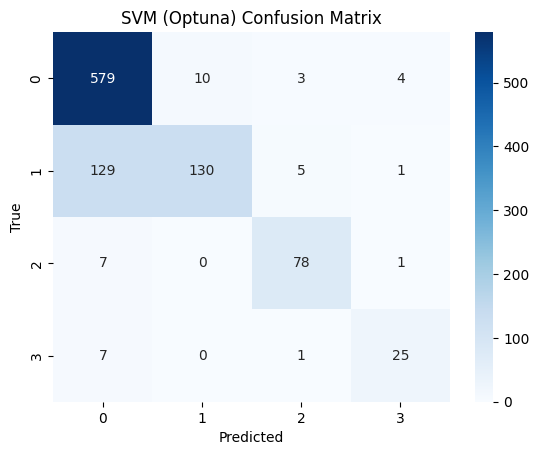

[I 2025-06-19 12:35:56,486] A new study created in memory with name: no-name-26dc153c-92a3-40a7-981b-47c7705a7e1c
[I 2025-06-19 12:36:06,707] Trial 0 finished with value: -0.780557863125988 and parameters: {'n_estimators': 142, 'max_depth': 23, 'min_samples_split': 7}. Best is trial 0 with value: -0.780557863125988.
[I 2025-06-19 12:36:14,602] Trial 1 finished with value: -0.7810683276487036 and parameters: {'n_estimators': 109, 'max_depth': 22, 'min_samples_split': 3}. Best is trial 1 with value: -0.7810683276487036.
[I 2025-06-19 12:36:21,849] Trial 2 finished with value: -0.7057927763997448 and parameters: {'n_estimators': 235, 'max_depth': 5, 'min_samples_split': 7}. Best is trial 1 with value: -0.7810683276487036.
[I 2025-06-19 12:36:43,856] Trial 3 finished with value: -0.7887229521174904 and parameters: {'n_estimators': 289, 'max_depth': 29, 'min_samples_split': 2}. Best is trial 3 with value: -0.7887229521174904.
[I 2025-06-19 12:36:59,590] Trial 4 finished with value: -0.77647


Best Random Forest Parameters from Optuna: {'n_estimators': 289, 'max_depth': 29, 'min_samples_split': 2}

Random Forest (Optuna Best) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       596
           1       0.94      0.43      0.59       265
           2       0.93      0.90      0.91        86
           3       0.94      0.45      0.61        33

    accuracy                           0.81       980
   macro avg       0.89      0.69      0.74       980
weighted avg       0.84      0.81      0.78       980



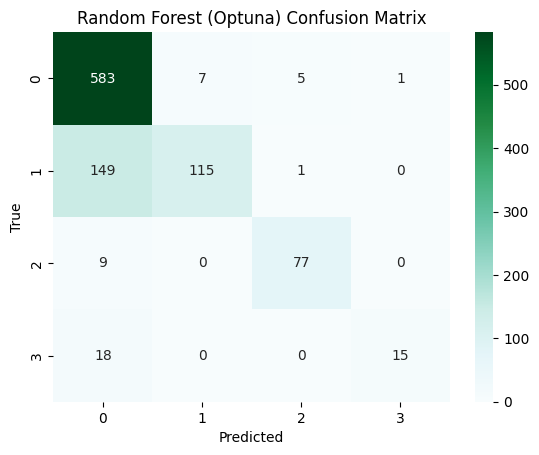

[I 2025-06-19 12:38:10,895] A new study created in memory with name: no-name-7f0f8576-138d-4ceb-afa3-af687fbd00ab
[I 2025-06-19 12:39:01,450] Trial 0 finished with value: 0.8341435541844225 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.1502928224972643, 'subsample': 0.8749280032701352, 'colsample_bytree': 0.6600221603976856, 'gamma': 0.07734266669358908, 'reg_alpha': 0.02911864582281498, 'reg_lambda': 1.2653212327763788}. Best is trial 0 with value: 0.8341435541844225.
[I 2025-06-19 12:39:43,915] Trial 1 finished with value: 0.8303162419500291 and parameters: {'n_estimators': 207, 'max_depth': 6, 'learning_rate': 0.1311618694630648, 'subsample': 0.5837854277717456, 'colsample_bytree': 0.7751814613209247, 'gamma': 0.3743701322581664, 'reg_alpha': 0.49041234926542154, 'reg_lambda': 1.6352891771524525}. Best is trial 0 with value: 0.8341435541844225.
[I 2025-06-19 12:40:16,069] Trial 2 finished with value: 0.8285298114015199 and parameters: {'n_estimators': 105,


Best hyperparameters (Bayesian/Optuna for XGBoost):
{'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.15893268458482293, 'subsample': 0.9210880433965527, 'colsample_bytree': 0.8748483852387225, 'gamma': 0.06614645177767042, 'reg_alpha': 0.19393112082595249, 'reg_lambda': 1.3531624492096532}

XGBoost (Optuna) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       596
           1       0.92      0.62      0.74       265
           2       0.90      0.95      0.93        86
           3       0.88      0.67      0.76        33

    accuracy                           0.86       980
   macro avg       0.88      0.80      0.83       980
weighted avg       0.86      0.86      0.85       980



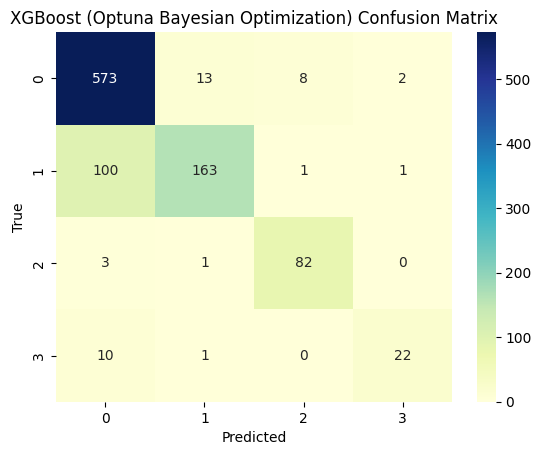

In [18]:
# Bayesian optimization for SVM
svm_objective = lambda trial: -np.mean(cross_val_score(
    SVC(
        C=trial.suggest_float("C", 0.1, 10.0, log=True),
        gamma=trial.suggest_float("gamma", 1e-4, 1e-1, log=True),
        kernel='rbf'
    ), X_train, y_train, cv=3, scoring='accuracy'))
optuna_svm = optuna.create_study()
optuna_svm.optimize(svm_objective, n_trials=10)
print("\nBest SVM Parameters from Optuna:", optuna_svm.best_params)
svm_best = SVC(**optuna_svm.best_params)
svm_best.fit(X_train, y_train)
y_pred_svm_optuna = svm_best.predict(X_test)
print("\nSVM (Optuna Best) Classification Report:")
print(classification_report(y_test, y_pred_svm_optuna))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_optuna), annot=True, fmt='d', cmap='Blues')
plt.title("SVM (Optuna) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bayesian optimization for Random Forest
rf_objective = lambda trial: -np.mean(cross_val_score(
    RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 300),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        random_state=42
    ), X_train, y_train, cv=3, scoring='accuracy'))
optuna_rf = optuna.create_study()
optuna_rf.optimize(rf_objective, n_trials=10)
print("\nBest Random Forest Parameters from Optuna:", optuna_rf.best_params)
rf_best = RandomForestClassifier(**optuna_rf.best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf_optuna = rf_best.predict(X_test)
print("\nRandom Forest (Optuna Best) Classification Report:")
print(classification_report(y_test, y_pred_rf_optuna))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_optuna), annot=True, fmt='d', cmap='BuGn')
plt.title("Random Forest (Optuna) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bayesian Optimization with Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("\nBest hyperparameters (Bayesian/Optuna for XGBoost):")
print(study.best_params)
best_xgb = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
best_xgb.fit(X_train, y_train)
y_pred_optuna_xgb = best_xgb.predict(X_test)
print("\nXGBoost (Optuna) Classification Report:")
print(classification_report(y_test, y_pred_optuna_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_optuna_xgb), annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost (Optuna Bayesian Optimization) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()